<a href="https://colab.research.google.com/github/Calaria/pytorch_models/blob/main/08.Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting setup

In [1]:
# using torcchvision v0.13 package
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torchvision import transforms
from torch import nn

# Install torchinfo if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
# Download going_modular
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 39.73 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create Datasets and DataLoaders

In [6]:
# create image size

IMG_SIZE = 224

# Create tranform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e8a59a088e0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(1))

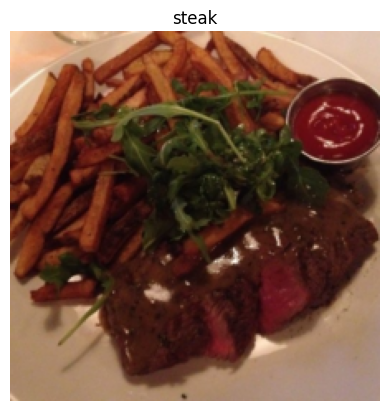

In [9]:
# Plot image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# Equation 1: split data into patches and create the class, position and patch embedding

## 4.1 Calculating patch embedding input and output shapes by hand

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16
# calculate number of patches
number_of_patches = int(height*width/patch_size**2)
number_of_patches

196

In [11]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#output shape
embedding_layer_output_shape = (number_of_patches,patch_size**2 * color_channels)

print(f"input shape: {embedding_layer_input_shape}")
print(f"output shape: {embedding_layer_output_shape}")

input shape: (224, 224, 3)
output shape: (196, 768)


## 4.2 Turn a image into patches

(-0.5, 223.5, 223.5, -0.5)

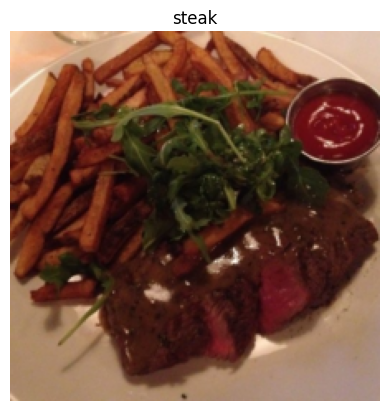

In [12]:
# view single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

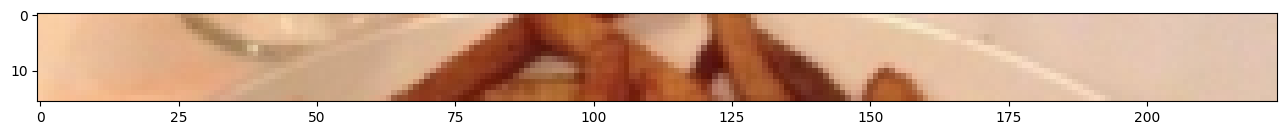

In [13]:
# change image shape to be compatitble with matplotlib
image = image.permute(1,2,0)#---->(height, width, color_channels)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image[:patch_size, :,:])

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0,"Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}")
print(f"Patch size: {patch_size} x {patch_size}")


Number of patches per row: 14.0
Patch size: 16 x 16


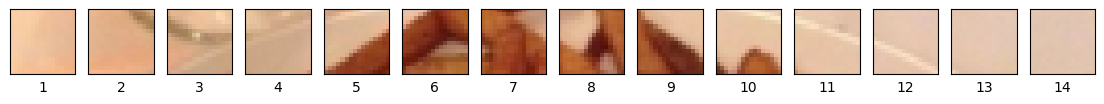

In [15]:
# create subplots
fig,axs = plt.subplots(nrows=1,
                      ncols=img_size//patch_size,
                      figsize=(num_patches, num_patches),
                      sharex=True,
                      sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image[:patch_size, patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Patch size: 16 x 16


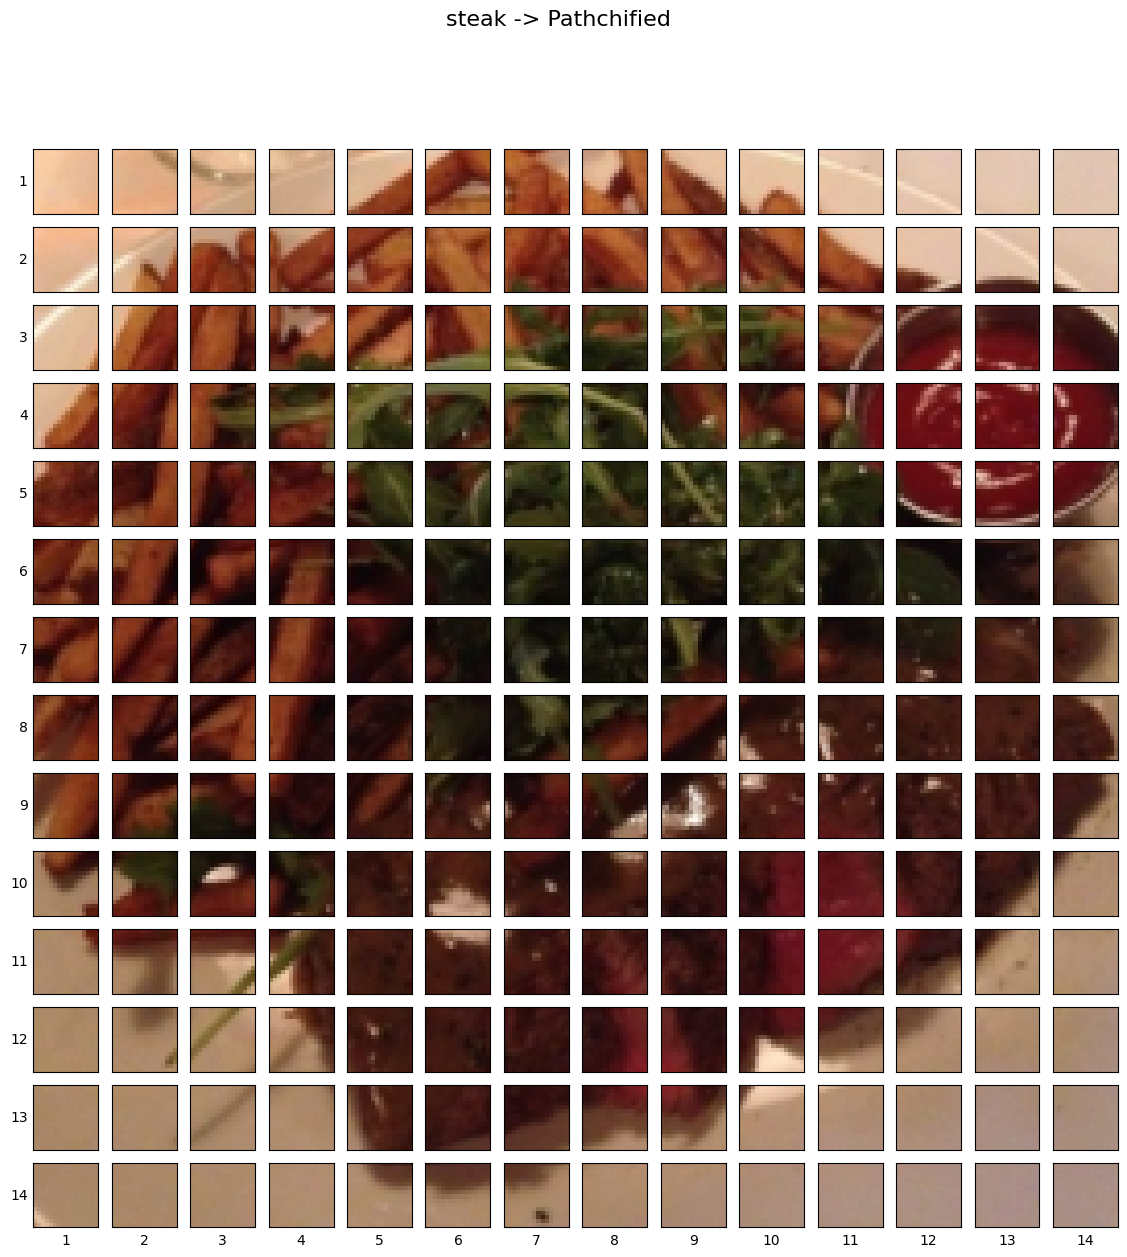

In [16]:
# Setup hyperparameters
img_size =224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0,"Imgae size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}")
print(f"Patch size: {patch_size} x {patch_size}")

# Create subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through geight and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image[patch_height:patch_height+patch_size,
                            patch_width:patch_width+patch_size,:])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].label_outer()
fig.suptitle(f"{class_names[label]} -> Pathchified", fontsize=16)
plt.show()

## 4.3 Create image patches with torch.nn.Conv2d

In [17]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

In [18]:
image.shape

torch.Size([224, 224, 3])

(-0.5, 223.5, 223.5, -0.5)

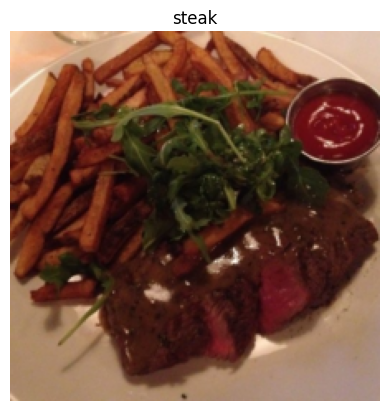

In [19]:
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)


In [20]:
image, label = image_batch[0], label_batch[0]

In [21]:
image_out_of_conv=conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Random indexes: [316, 27, 111, 405, 624]


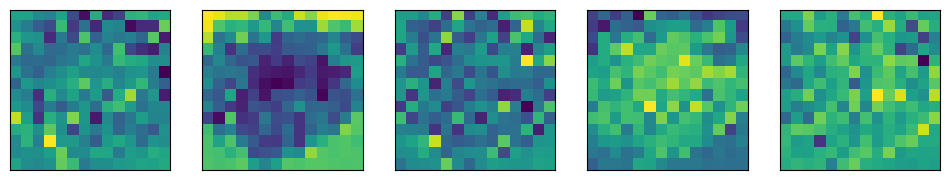

In [22]:
# Plot 5 feature maps
import random
random_indexes = random.sample(range(0,758),k=5)
print(f"Random indexes: {random_indexes}")
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))
for i, index in enumerate(random_indexes):
  image_conv_feature = image_out_of_conv[:,index,:,:]
  axs[i].imshow(image_conv_feature.squeeze().detach().numpy())
  axs[i].set(xticks=[], yticks=[], xticklabels=[],yticklabels=[])

In [23]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2291, -0.1979, -0.1811, -0.2158, -0.0542, -0.0222, -0.0353,
           -0.2472, -0.0690, -0.2093, -0.2779, -0.2844, -0.2866, -0.2896],
          [-0.2359, -0.1780,  0.0561, -0.0080,  0.0623, -0.0869, -0.0234,
            0.0211, -0.0323, -0.0975, -0.0880, -0.3084, -0.1857, -0.2981],
          [-0.2721, -0.0253, -0.1232, -0.0887, -0.1384, -0.0705, -0.1172,
           -0.0862, -0.0633,  0.0274, -0.1147, -0.0073, -0.0443, -0.0429],
          [-0.1018, -0.0884, -0.1051, -0.0317, -0.1247,  0.0545, -0.0027,
           -0.0707, -0.0730, -0.0352, -0.1061, -0.0943, -0.0586, -0.0815],
          [ 0.0287, -0.0128,  0.0630, -0.0521, -0.0509, -0.0551, -0.0517,
           -0.0558, -0.0754, -0.0126, -0.0245, -0.0174, -0.1633, -0.0920],
          [-0.0048,  0.0351, -0.0725,  0.0224, -0.0172, -0.0345,  0.0062,
           -0.0207, -0.0521,  0.0144, -0.0490, -0.0696, -0.0551, -0.1062],
          [-0.0074, -0.0080,  0.0446, -0.1038, -0.0408, -0.0321, -0.0379,
           -0.0473, -0.0643, -0.

## 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [24]:
print(f"Current tensor shape: {image_out_of_conv.shape}")

Current tensor shape: torch.Size([1, 768, 14, 14])


In [25]:
flatten=nn.Flatten(start_dim=2,
                   end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened feature map shape: torch.Size([1, 768, 196])


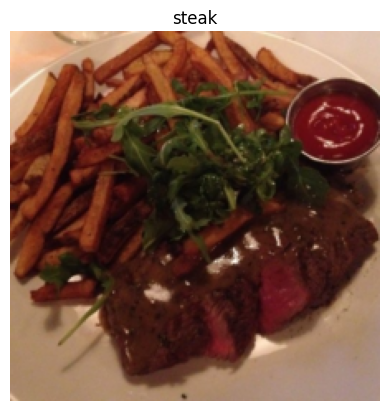

In [26]:
# 1.View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2.Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3.Flatten the feature maps
image_out_of_conv_flagttened = flatten(image_out_of_conv)
print(f"Flattened feature map shape: {image_out_of_conv_flagttened.shape}")


In [27]:
image_out_of_conv_flattended_reshaped = image_out_of_conv_flagttened.permute(0,2,1)
image_out_of_conv_flattended_reshaped.shape

torch.Size([1, 196, 768])

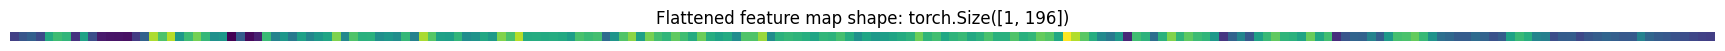

In [28]:
# Visualize the flattended feature maps
single_flattened_feature_map = image_out_of_conv_flattended_reshaped[:, :, 0]
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

## 4.5 Turning the ViT patch embedding layer into a Pytorch module


In [29]:
class PatchEmbedding(nn.Module):
  # 1. Initialize the class
  def __init__(self,
               in_channels:int=3,
               patch_size:int=3,
               embedding_dim:int=768):
    super().__init__()

    # 2. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)

    # 3. Create a layer to flatten the patch feature maps into a single dimention
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  # 4. Define the forward method
  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size ==0, f"Image resolution {image_resolution} is not divisible by patch size {patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0,2,1)

In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
print(f"Input shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [31]:
# Get a summary
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 5476, 768]       --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 74, 74]     21,504               True
├─Flatten (flatten)                      [1, 768, 74, 74]     [1, 768, 5476]       --                   --
Total params: 21,504
Trainable params: 21,504
Non-trainable params: 0
Total mult-adds (M): 117.76
Input size (MB): 0.60
Forward/backward pass size (MB): 33.64
Params size (MB): 0.09
Estimated Total Size (MB): 34.33

## 4.6 Create the class token embedding

In [32]:
# View the patch embedding
print(patch_embedded_image)
print(patch_embedded_image.shape)


tensor([[[-0.8384,  0.1266, -0.1849,  ...,  0.5783, -0.4258,  0.3485],
         [-0.8006,  0.0782, -0.1662,  ...,  0.5228, -0.3607,  0.2894],
         [-0.6605,  0.1877, -0.1303,  ...,  0.5441, -0.3703,  0.3336],
         ...,
         [-0.6366,  0.1312, -0.1539,  ...,  0.4373, -0.2923,  0.2290],
         [-0.6329,  0.1262, -0.1610,  ...,  0.4436, -0.2940,  0.2314],
         [-0.6350,  0.1342, -0.1575,  ...,  0.4512, -0.2926,  0.2287]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


In [33]:
# Create class token embedding
batch_size = patch_embedded_image.shape[0]
num_patches = patch_embedded_image.shape[1]
embedding_dim = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
print(class_token[:, :, :10])
print(class_token.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 1, 768])


In [34]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(patch_embedded_image_with_class_embedding.shape)
print(patch_embedded_image_with_class_embedding)

torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8384,  0.1266, -0.1849,  ...,  0.5783, -0.4258,  0.3485],
         [-0.8006,  0.0782, -0.1662,  ...,  0.5228, -0.3607,  0.2894],
         ...,
         [-0.6366,  0.1312, -0.1539,  ...,  0.4373, -0.2923,  0.2290],
         [-0.6329,  0.1262, -0.1610,  ...,  0.4436, -0.2940,  0.2314],
         [-0.6350,  0.1342, -0.1575,  ...,  0.4512, -0.2926,  0.2287]]],
       grad_fn=<CatBackward0>)


## Create position embedding

In [35]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8384,  0.1266, -0.1849,  ...,  0.5783, -0.4258,  0.3485],
          [-0.8006,  0.0782, -0.1662,  ...,  0.5228, -0.3607,  0.2894],
          ...,
          [-0.6366,  0.1312, -0.1539,  ...,  0.4373, -0.2923,  0.2290],
          [-0.6329,  0.1262, -0.1610,  ...,  0.4436, -0.2940,  0.2314],
          [-0.6350,  0.1342, -0.1575,  ...,  0.4512, -0.2926,  0.2287]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate number of patches N
number_of_patches = int((height * width)/patch_size ** 2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
print(position_embedding[:,:10,:10])
print(f"Position embedding shape: {position_embedding.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768])


In [37]:
# add position embedding to the sequence
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding.shape)
print(patch_and_position_embedding)

torch.Size([1, 197, 768])
tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1616, 1.1266, 0.8151,  ..., 1.5783, 0.5742, 1.3485],
         [0.1994, 1.0782, 0.8338,  ..., 1.5228, 0.6393, 1.2894],
         ...,
         [0.3634, 1.1312, 0.8461,  ..., 1.4373, 0.7077, 1.2290],
         [0.3671, 1.1262, 0.8390,  ..., 1.4436, 0.7060, 1.2314],
         [0.3650, 1.1342, 0.8425,  ..., 1.4512, 0.7074, 1.2287]]],
       grad_fn=<AddBackward0>)


## Put it all together

In [38]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Equation 2:Multi-Head Attention(MSA)

In [39]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:float=0):
    super().__init__()
    # Create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    # Create the multi-head attension layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)
  # Create a forward() method
  def forward(self, x):
    x=self.layer_norm(x)
    attn_output,_=self.multihead_attn(query=x,
                                      key=x,
                                      value=x,
                                      need_weights=False)
    return attn_output


In [40]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
patch_and_position_embedding.shape, patched_image_through_msa_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

## Equation 3 with PyTorch layers

In [41]:
class MLPBlock(nn.Module):
  # Initialize the class
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()
    # Creat the Norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the Multilayer perceptron layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x=self.layer_norm(x)
    x=self.mlp(x)
    return x

In [42]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_msa_block.shape, patched_image_through_mlp_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

# Transformer Encoder

## Create a transformer encoder by custom made layers

In [43]:
class TransformerEncoderBlock(nn.Module):
  # Initialize the class
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()

    # Create MSA block
    self.msa_block =MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                num_heads=num_heads,
                                                attn_dropout=attn_dropout)
    # Create MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self,x):
      x=self.msa_block(x)+x
      x=self.mlp_block(x)+x
      return x


In [44]:
# Test the above code
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [45]:
## Create a Transformer Encoder with Pytorch's Transformer layers
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

In [46]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Create ViT

In [47]:
class ViT(nn.Module):
  # 1. Initialize the class with hyperparamters
  def __init__(self,
               img_size:int=224,
               in_channels:int = 3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000):
    super().__init__()

    # 2.Make sure that image_size % patch_size==0
    assert img_size % patch_size ==0, f"Image size must be divisible by patch size {patch_size}"

    # 3. Calculate number of patches
    self.num_patches = (img_size*img_size)//patch_size**2

    # 4.Create learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)
    # 5. Create learnable position embedding
    self.position_embedding =nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                          requires_grad=True)
    # 6.Create embedding of dropout value
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    # 7.Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                           patch_size=patch_size,
                                           embedding_dim=embedding_dim)

    # 8. Create transformer encoder layers
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # 9.Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

    # 10. Define the forward method
  def forward(self, x):
      # 11.Get batch size
      batch_size=x.shape[0]

      # 12.Create class token embedding
      class_token = self.class_embedding.expand(batch_size, -1, -1)

      # 13.Create patch embedding
      x=self.patch_embedding(x)

      # 14.Concat class embedding and patch embedding
      x=torch.cat((class_token, x), dim=1)

      # 15.Add position embedding
      x=x+self.position_embedding

      # 16. Run embedding dropout
      x=self.embedding_dropout(x)

      # 17. Run transformer encoder
      x=self.transformer_encoder(x)

      # 18.Run classifier head
      x=self.classifier(x[:,0])

      return x



In [48]:
# Example of class embedding and expanding over a batch dimention
batch_size=32
class_token_embedding_single= nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Class token embedding shape: {class_token_embedding_single.shape}")
print(f"Class token embedding expanded shape: {class_token_embedding_expanded.shape}")

Class token embedding shape: torch.Size([1, 1, 768])
Class token embedding expanded shape: torch.Size([32, 1, 768])


In [49]:
class_names

['pizza', 'steak', 'sushi']

In [50]:
# Test ViT class
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT
vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## visualize ViT model

In [51]:
from torchinfo import summary
summary(model=vit,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## Training ViT model

In [52]:
# from going_modular.going_modular import engine

# optimizer = torch.optim.Adam(params=vit.parameters(),
#                              lr=3e-3,
#                              betas=(0.9, 0.999),
#                              weight_decay=0.3)

# loss_fn = torch.nn.CrossEntropyLoss()

# # Set the seeds
# set_seeds()

# # Train the model
# results = engine.train(model=vit,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)

## Get a pretrained ViT model and Create a feature extractor

In [53]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [54]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [55]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# 3. Freeze the weights
for param in pretrained_vit.parameters():
  param.requires_grad = False

# 4. Change the classifier head
set_seeds()
pretrained_vit.heads=nn.Linear(in_features=768,out_features=len(class_names)).to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 164MB/s]


In [56]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        #col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Prepare data for ViT model

In [57]:
from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [58]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [59]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [60]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


## Train the ViT model

In [61]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the ViT model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


## Plot loss curves

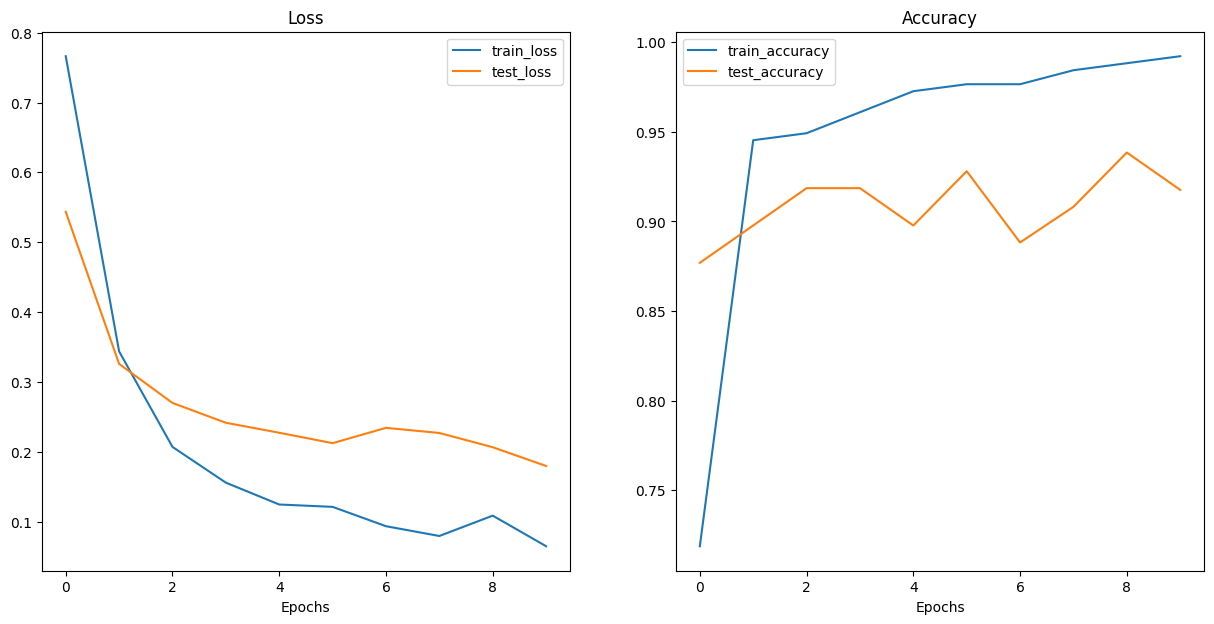

In [62]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## Save the ViT model

In [63]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [64]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


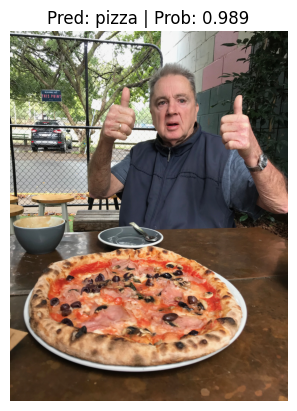

In [65]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)